# Fine-Tuning of OpenAI detector

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab Notebooks/ai_text_detection/cookbooks

/content/drive/MyDrive/Colab Notebooks/ai_text_detection/cookbooks


In [85]:
import json
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
# import tqdm
from sklearn.utils import resample
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
import sys
import os
sys.path.append("/mnt/data/bobae/ai_text_detection")

from utils.cuda_helper import *

### Set GPU

In [3]:
print_gpu_usage()

Current GPU memory usage: 0.00 MB
Maximum GPU memory usage: 0.00 MB


In [4]:
print_gpu_devie_name()

cuda 0: NVIDIA GeForce RTX 2080 Ti
cuda 1: NVIDIA GeForce RTX 2080 Ti


In [28]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
num_gpus = torch.cuda.device_count()

if num_gpus>1:
    device = "cuda:0"

In [40]:
device

'cuda:0'

In [59]:
# Get the device properties for the current GPU
device_props = torch.cuda.get_device_properties(torch.cuda.current_device())
print(device_props)

# Print the total GPU memory in gigabytes
total_gpu_memory = device_props.total_memory / (1024**3)
print(f"Total GPU memory: {total_gpu_memory:.2f} GB")

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Total GPU memory: 10.75 GB


### Load json data file and convert to dataframe

In [7]:
# human data

# loads a tofel dataset
with open('../dataset/human/tofel.json', "r") as f:
    h_tofel_dataset = json.load(f)

# loads an arxiv dataset
with open('../dataset/human/arxiv.json', "r") as f:
    h_arxiv_dataset = json.load(f)

# loads student essay
with open('../dataset/human/student_essay.json', "r") as f:
    h_essay_dataset = json.load(f)

# loads student computer essay
with open('../dataset/human/student_cs_essay.json', "r") as f:
    h_essay_cs_dataset = json.load(f)

In [8]:
# gpt data

# loads a tofel dataset
with open('../dataset/ai/gpt2medium_tofel.json', "r") as f:
    gpt_tofel_dataset = json.load(f)

# loads an arxiv dataset
with open('../dataset/ai/gpt2medium_arxiv.json', "r") as f:
    gpt_arxiv_dataset = json.load(f)

# loads student essay
with open('../dataset/ai/gpt2medium_essay.json', "r") as f:
    gpt_essay_dataset = json.load(f)

# loads student computer essay
with open('../dataset/ai/gpt2medium_essay_cs.json', "r") as f:
    gpt_essay_cs_dataset = json.load(f)

# loads a tofel dataset
with open('../dataset/ai/gpt35_tofel.json', "r") as f:
    gpt_35_tofel_dataset = json.load(f)

# loads student computer essay
with open('../dataset/ai/gpt35_essay_cs.json', "r") as f:
    gpt_35_essay_cs_dataset = json.load(f)

In [9]:
h_dataset = []
for i in [h_tofel_dataset, h_arxiv_dataset, h_essay_dataset, h_essay_cs_dataset]:
    h_dataset.extend(i)

len(h_dataset)

2478

In [10]:
gpt_dataset = []
for i in [gpt_tofel_dataset, gpt_arxiv_dataset, gpt_essay_dataset, gpt_essay_cs_dataset,
          gpt_35_tofel_dataset, gpt_35_essay_cs_dataset]:
    gpt_dataset.extend(i)

len(gpt_dataset)

2956

In [11]:
dct = {
    "text": [item['input'] for item in h_dataset] + [item['input'] for item in gpt_dataset],
    "label": [item['label'] for item in h_dataset] + [item['label'] for item in gpt_dataset],
}

df = pd.DataFrame(dct)

def label_to_numeric(value):
    if value == "human":
        return 1
    else:
        return 0

df['target'] = df['label'].apply(lambda x: label_to_numeric(x))

In [12]:
class_counts = df['target'].value_counts()
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Separate majority and minority classes
majority_df = df[df['target'] == majority_class]
minority_df = df[df['target'] == minority_class]

# Undersample majority class
undersampled_majority_df = resample(majority_df,
                                    replace=False,  # Sample without replacement
                                    n_samples=len(minority_df),  # Match minority class size
                                    random_state=42)  # For reproducibility

# Combine minority class with undersampled majority class
undersampled_df = pd.concat([undersampled_majority_df, minority_df])
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
df = undersampled_df
df

,text,label,target
0,The spectral action on noncommutative torus is...,human,1
1,Computerized Ordering System Thesis\n\nIntrodu...,ai,0
2,We report observation of spin-orbit Berry's ph...,human,1
3,We report observation of spin-orbit Berry's ph...,ai,0
4,\n\nThe first thing you need to do is to get y...,ai,0
...,...,...,...
4951,The Lessons from Yusufiyah Essay\n\nThe Lesson...,human,1
4952,We present an algorithm that produces the clas...,ai,0
4953,In this paper we investigate the optimal contr...,human,1
4954,Correlation between Socioeconomic Status and H...,human,1


### Preparing the Dataset and Dataloader

In [13]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = self.data.text
        self.target = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            pad_to_max_length=True,
            max_length=self.max_len,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.target[index], dtype=torch.float)
        }

In [14]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/roberta-large-openai-detector")
model = AutoModelForSequenceClassification.from_pretrained("openai-community/roberta-large-openai-detector")

Some weights of the model checkpoint at openai-community/roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [50]:
train_size = 0.8
train_data=df.sample(frac=train_size, random_state=42)
test_data=df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (4956, 3)
TRAIN Dataset: (3965, 3)
TEST Dataset: (991, 3)


In [51]:
train_params = {'batch_size': TRAIN_BATCH_SIZE, 'shuffle': True, 'num_workers': 0}
test_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': True, 'num_workers': 0}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

### Fine Tuning Functions

In [52]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [53]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [54]:
# Training Loop with Early Stopping:**
def train_model(epochs, file_name, model):
  best_loss = float('inf')
  best_model_weights = None
  patience = 10

  train_losses = []
  valid_losses = []

  model = model.to(device)
  for epoch in range(1, epochs+1):
    n_correct = 0
    tr_loss = 0
    nb_tr_steps = 0; nb_tr_examples = 0;

    ###################
    # train the model #
    ###################
    model.train()
    for i, data in enumerate(tqdm(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss_ = loss_function(outputs.logits, targets)

        tr_loss += loss_.item()
        big_val, big_idx = torch.max(outputs.logits, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if i%100==0:
            step_loss = tr_loss/nb_tr_steps
            step_acc = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 100 steps: {step_loss}")
            print(f"Training Accuracy per 100 steps: {step_acc}")
            print("=="*50)

        optimizer.zero_grad()
        loss_.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    train_epoch_loss = tr_loss/nb_tr_steps
    train_epoch_acc = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {train_epoch_loss}")
    print(f"Training Accuracy Epoch: {train_epoch_acc}")
    train_losses.append(train_epoch_loss)

    # ######################
    # # validate the model #
    # ######################
    # model.eval()  # Set model to evaluation mode
    # val_n_correct = 0; val_n_wrong = 0; total = 0;
    # val_loss = 0;
    # nb_val_steps = 0; nb_val_example = 0;
    # with torch.no_grad():  # Disable gradient calculation for validation
    #     for i, data in enumerate(tqdm(testing_loader)):
    #       ids = data['ids'].to(device, dtype = torch.long)
    #       mask = data['mask'].to(device, dtype = torch.long)
    #       token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
    #       targets = data['target'].to(device, dtype = torch.long)

    #       outputs = model(ids, mask, token_type_ids)
    #       loss_ = loss_function(outputs.logits, targets)

    #       val_loss += loss_.item()
    #       big_val, big_idx = torch.max(outputs.logits, dim=1)
    #       val_n_correct += calcuate_accuracy(big_idx, targets)

    #       nb_val_steps += 1
    #       nb_val_examples += targets.size(0)

    #       if i%100==0:
    #         step_loss = tr_loss/nb_tr_steps
    #         step_acc = (n_correct*100)/nb_tr_examples
    #         print(f"Validation Loss per 100 steps: {step_loss}")
    #         print(f"Validation Accuracy per 100 steps: {step_acc}")

    #       if val_loss < best_loss:
    #         best_loss = val_loss
    #         best_model_weights = copy.deepcopy(model.state_dict())
    #         patience = 10  # Reset patience counter
    #       else:
    #         patient -= 1
    #         if patient == 0:
    #           print("="*50)
    #           print("="*20, "early stop", "="*20)
    #           print("="*50)
    #           break

    # valid_epoch_loss = val_loss/nb_val_steps
    # valid_epoch_accu = (val_n_correct*100)/nb_val_example
    # print(f"Validation Loss Epoch: {valid_epoch_loss}")
    # print(f"Validation Accuracy Epoch: {valid_epoch_accu}")
    # valid_losses.append(valid_epoch_loss)


    path = '/content/drive/MyDrive/Colab Notebooks/ai_text_detection/models/'+file_name+'_epoch'+str(epoch)+'.pth'
    torch.save(model.state_dict(), path)

  return train_losses, valid_losses

In [63]:
train_losses, valid_losses = train_model(4, str('23May2024_2'), model)

  0%|          | 0/496 [00:00<?, ?it/s]

Training Loss per 100 steps: 0.7031255960464478
Training Accuracy per 100 steps: 87.5


 20%|██        | 100/496 [01:50<07:19,  1.11s/it]

Training Loss per 100 steps: 0.5198084413267599
Training Accuracy per 100 steps: 83.91089108910892


 40%|████      | 200/496 [03:41<05:28,  1.11s/it]

Training Loss per 100 steps: 0.5553283661103515
Training Accuracy per 100 steps: 83.3955223880597


 60%|██████    | 300/496 [05:32<03:37,  1.11s/it]

Training Loss per 100 steps: 0.5559600055576658
Training Accuracy per 100 steps: 83.80398671096346


 81%|████████  | 400/496 [07:23<01:46,  1.10s/it]

Training Loss per 100 steps: 0.5571192507585627
Training Accuracy per 100 steps: 83.8216957605985


100%|██████████| 496/496 [09:09<00:00,  1.11s/it]


The Total Accuracy for Epoch 1: 83.5561160151324
Training Loss Epoch: 0.5589507854864707
Training Accuracy Epoch: 83.5561160151324


  0%|          | 0/496 [00:00<?, ?it/s]

Training Loss per 100 steps: 1.6776599884033203
Training Accuracy per 100 steps: 75.0


 20%|██        | 100/496 [01:50<07:23,  1.12s/it]

Training Loss per 100 steps: 0.5222560936668058
Training Accuracy per 100 steps: 84.77722772277228


 40%|████      | 200/496 [03:41<05:27,  1.11s/it]

Training Loss per 100 steps: 0.5769979786475314
Training Accuracy per 100 steps: 83.33333333333333


 60%|██████    | 300/496 [05:32<03:37,  1.11s/it]

Training Loss per 100 steps: 0.5503550191855435
Training Accuracy per 100 steps: 83.63787375415282


 81%|████████  | 400/496 [07:23<01:46,  1.11s/it]

Training Loss per 100 steps: 0.5658189091736223
Training Accuracy per 100 steps: 83.22942643391521


100%|██████████| 496/496 [09:10<00:00,  1.11s/it]


The Total Accuracy for Epoch 2: 83.95964691046659
Training Loss Epoch: 0.555270833052477
Training Accuracy Epoch: 83.95964691046659


  0%|          | 0/496 [00:00<?, ?it/s]

Training Loss per 100 steps: 0.12199705839157104
Training Accuracy per 100 steps: 100.0


 20%|██        | 100/496 [01:50<07:22,  1.12s/it]

Training Loss per 100 steps: 0.5885796867274117
Training Accuracy per 100 steps: 83.7871287128713


 40%|████      | 200/496 [03:41<05:29,  1.11s/it]

Training Loss per 100 steps: 0.5667090179463524
Training Accuracy per 100 steps: 84.32835820895522


 60%|██████    | 300/496 [05:33<03:38,  1.11s/it]

Training Loss per 100 steps: 0.5505517761461264
Training Accuracy per 100 steps: 84.59302325581395


 81%|████████  | 400/496 [07:24<01:46,  1.11s/it]

Training Loss per 100 steps: 0.5587301412527623
Training Accuracy per 100 steps: 84.03990024937656


100%|██████████| 496/496 [09:10<00:00,  1.11s/it]


The Total Accuracy for Epoch 3: 84.01008827238336
Training Loss Epoch: 0.5591309158311736
Training Accuracy Epoch: 84.01008827238336


  0%|          | 0/496 [00:00<?, ?it/s]

Training Loss per 100 steps: 0.45658066868782043
Training Accuracy per 100 steps: 87.5


 20%|██        | 100/496 [01:50<07:22,  1.12s/it]

Training Loss per 100 steps: 0.6353326649543377
Training Accuracy per 100 steps: 81.55940594059406


 40%|████      | 200/496 [03:42<05:30,  1.12s/it]

Training Loss per 100 steps: 0.5853137497266578
Training Accuracy per 100 steps: 82.96019900497512


 60%|██████    | 300/496 [05:33<03:36,  1.11s/it]

Training Loss per 100 steps: 0.5735118876016417
Training Accuracy per 100 steps: 83.34717607973423


 81%|████████  | 400/496 [07:24<01:46,  1.11s/it]

Training Loss per 100 steps: 0.5700660363905726
Training Accuracy per 100 steps: 83.16708229426433


100%|██████████| 496/496 [09:10<00:00,  1.11s/it]


The Total Accuracy for Epoch 4: 83.203026481715
Training Loss Epoch: 0.5654975044805812
Training Accuracy Epoch: 83.203026481715


In [64]:
train_losses, valid_losses

([0.5589507854864707,
  0.555270833052477,
  0.5591309158311736,
  0.5654975044805812],
 [])

In [42]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
def train(epoch, model, device):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model = model.to(device)
    model.train()

    # for i, data in tqdm(enumerate(training_loader, 0), total=len(training_loader)):
    # for _, data in tqdm(enumerate(training_loader, 0)):
    for i, data in enumerate(tqdm(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs.logits, targets)

        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.logits, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if i%100==0:
            step_loss = tr_loss/nb_tr_steps
            step_acc = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 100 steps: {step_loss}")
            print(f"Training Accuracy per 100 steps: {step_acc}")
            print("=="*50)

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_acc = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_acc}")

    return epoch_loss, epoch_acc, step_loss, step_acc

### Fine Tuning without checking validation error

In [95]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [61]:
EPOCHS = 5

train_result = []
for epoch in range(EPOCHS):
    train_result.append(train(epoch, model, device))

    # with gpt paraphrased data, epoch=10
    file_name = "".join('../models/openai_finetune_models/20240523_v1_epoch'+str(epoch)+'.pth')
    torch.save(model, file_name)

  0%|                                                     | 0/496 [00:00<?, ?it/s]

Training Loss per 100 steps: 0.6350618004798889
Training Accuracy per 100 steps: 75.0


 20%|████████▊                                  | 101/496 [00:39<02:34,  2.56it/s]

Training Loss per 100 steps: 0.161789864219845
Training Accuracy per 100 steps: 94.05940594059406


 41%|█████████████████▍                         | 201/496 [01:18<01:55,  2.56it/s]

Training Loss per 100 steps: 0.11646890107933802
Training Accuracy per 100 steps: 95.58457711442786


 61%|██████████████████████████                 | 301/496 [01:57<01:16,  2.56it/s]

Training Loss per 100 steps: 0.11783986132993422
Training Accuracy per 100 steps: 95.59800664451828


 81%|██████████████████████████████████▊        | 401/496 [02:36<00:37,  2.56it/s]

Training Loss per 100 steps: 0.10597007502055614
Training Accuracy per 100 steps: 96.16583541147132


100%|███████████████████████████████████████████| 496/496 [03:13<00:00,  2.56it/s]


The Total Accuracy for Epoch 0: 96.54476670870113
Training Loss Epoch: 0.09538349798611072
Training Accuracy Epoch: 96.54476670870113


  0%|                                             | 1/496 [00:00<01:38,  5.04it/s]

Training Loss per 100 steps: 0.019245991483330727
Training Accuracy per 100 steps: 100.0


 20%|████████▊                                  | 101/496 [00:39<02:34,  2.55it/s]

Training Loss per 100 steps: 0.02593569398314766
Training Accuracy per 100 steps: 99.38118811881188


 41%|█████████████████▍                         | 201/496 [01:18<01:55,  2.55it/s]

Training Loss per 100 steps: 0.02813964438669856
Training Accuracy per 100 steps: 99.31592039800995


 61%|██████████████████████████                 | 301/496 [01:57<01:16,  2.55it/s]

Training Loss per 100 steps: 0.02554208322941013
Training Accuracy per 100 steps: 99.25249169435216


 81%|██████████████████████████████████▊        | 401/496 [02:36<00:37,  2.55it/s]

Training Loss per 100 steps: 0.02392187034613987
Training Accuracy per 100 steps: 99.28304239401496


100%|███████████████████████████████████████████| 496/496 [03:13<00:00,  2.56it/s]


The Total Accuracy for Epoch 1: 99.21815889029004
Training Loss Epoch: 0.02642844717111955
Training Accuracy Epoch: 99.21815889029004


  0%|                                             | 1/496 [00:00<01:35,  5.16it/s]

Training Loss per 100 steps: 0.025118637830018997
Training Accuracy per 100 steps: 100.0


 20%|████████▊                                  | 101/496 [00:39<02:34,  2.55it/s]

Training Loss per 100 steps: 0.05435948150931502
Training Accuracy per 100 steps: 98.01980198019803


 41%|█████████████████▍                         | 201/496 [01:18<01:55,  2.55it/s]

Training Loss per 100 steps: 0.04124121629380776
Training Accuracy per 100 steps: 98.50746268656717


 61%|██████████████████████████                 | 301/496 [01:57<01:16,  2.55it/s]

Training Loss per 100 steps: 0.03577621777517183
Training Accuracy per 100 steps: 98.67109634551495


 81%|██████████████████████████████████▊        | 401/496 [02:36<00:37,  2.55it/s]

Training Loss per 100 steps: 0.029990090859532494
Training Accuracy per 100 steps: 98.90897755610973


100%|███████████████████████████████████████████| 496/496 [03:14<00:00,  2.55it/s]


The Total Accuracy for Epoch 2: 98.94073139974779
Training Loss Epoch: 0.028778374794866626
Training Accuracy Epoch: 98.94073139974779


  0%|                                             | 1/496 [00:00<01:34,  5.24it/s]

Training Loss per 100 steps: 0.0018950925441458821
Training Accuracy per 100 steps: 100.0


 20%|████████▊                                  | 101/496 [00:39<02:34,  2.55it/s]

Training Loss per 100 steps: 0.003023727395569463
Training Accuracy per 100 steps: 99.87623762376238


 41%|█████████████████▍                         | 201/496 [01:18<01:55,  2.55it/s]

Training Loss per 100 steps: 0.01524479753877597
Training Accuracy per 100 steps: 99.68905472636816


 61%|██████████████████████████                 | 301/496 [01:57<01:16,  2.55it/s]

Training Loss per 100 steps: 0.020132176766494612
Training Accuracy per 100 steps: 99.46013289036544


 81%|██████████████████████████████████▊        | 401/496 [02:37<00:37,  2.55it/s]

Training Loss per 100 steps: 0.018579235500519622
Training Accuracy per 100 steps: 99.50124688279301


100%|███████████████████████████████████████████| 496/496 [03:14<00:00,  2.55it/s]


The Total Accuracy for Epoch 3: 99.49558638083228
Training Loss Epoch: 0.018037250458233286
Training Accuracy Epoch: 99.49558638083228


  0%|                                             | 1/496 [00:00<01:38,  5.02it/s]

Training Loss per 100 steps: 0.005420683417469263
Training Accuracy per 100 steps: 100.0


 20%|████████▊                                  | 101/496 [00:39<02:35,  2.55it/s]

Training Loss per 100 steps: 0.01965596848588188
Training Accuracy per 100 steps: 99.75247524752476


 41%|█████████████████▍                         | 201/496 [01:18<01:55,  2.55it/s]

Training Loss per 100 steps: 0.01212998272692414
Training Accuracy per 100 steps: 99.81343283582089


 61%|██████████████████████████                 | 301/496 [01:57<01:16,  2.55it/s]

Training Loss per 100 steps: 0.010782920191450465
Training Accuracy per 100 steps: 99.70930232558139


 81%|██████████████████████████████████▊        | 401/496 [02:37<00:37,  2.55it/s]

Training Loss per 100 steps: 0.011466645034826407
Training Accuracy per 100 steps: 99.6571072319202


100%|███████████████████████████████████████████| 496/496 [03:14<00:00,  2.55it/s]


The Total Accuracy for Epoch 4: 99.62168978562421
Training Loss Epoch: 0.013993044867088283
Training Accuracy Epoch: 99.62168978562421


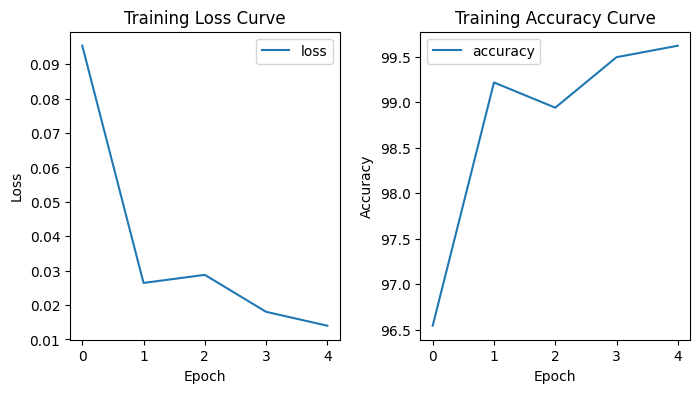

In [87]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the loss curve on the first subplot
ax1.plot(range(len(train_result)), [item[0] for item in train_result], label="loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Curve')
ax1.legend()

# Plot another metric on the second subplot
# Replace the following line with your desired plot
ax2.plot(range(len(train_result)), [item[1] for item in train_result], label="accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy Curve')
ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

In [82]:
# test
!python ../models/openai_finetune_detector.py --model_name "20240523_v1_epoch0.pth" --text "My name is bobae bak" 
!python ../models/openai_finetune_detector.py --model_name "20240523_v1_epoch1.pth" --text "My name is bobae bak" 
!python ../models/openai_finetune_detector.py --model_name "20240523_v1_epoch2.pth" --text "My name is bobae bak" 
!python ../models/openai_finetune_detector.py --model_name "20240523_v1_epoch3.pth" --text "My name is bobae bak" 
!python ../models/openai_finetune_detector.py --model_name "20240523_v1_epoch4.pth" --text "My name is bobae bak" 
    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
{'Fake': 0.37054572, 'Real': 0.6294543}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
{'Fake': 0.3325712, 'Real': 0.6674288}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
{'Fake': 0.43663213, 'Real': 0.5633679}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
{'Fake': 0.17202552, 'Real': 0.82797444}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
{'Fake': 0.11006163, 'Real': 0.88993835}


### Validate

In [90]:
def valid(model, testing_loader):
    model = model.to(device)
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        # for _, data in tqdm(enumerate(testing_loader, 0)):
        for i, data in enumerate(iter(testing_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['target'].to(device, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_function(outputs.logits, targets)

            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.logits, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if i%100==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_loss, epoch_accu

In [91]:
# model_1 validation
model_1 = torch.load('../models/openai_finetune_models/20240523_v1_epoch0.pth')
val_epoch_loss, val_epoch_acc = valid(model_1, testing_loader)
print(val_epoch_loss, val_epoch_acc)

/home/bobae/miniconda3/envs/ai_detector/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Validation Loss per 100 steps: 0.14860263466835022
Validation Accuracy per 100 steps: 100.0
Validation Loss per 100 steps: 0.08055920187167197
Validation Accuracy per 100 steps: 96.65841584158416
Validation Loss Epoch: 0.08093919815409238
Validation Accuracy Epoch: 96.56912209889
0.08093919815409238 96.56912209889


In [94]:
# model_4 validation

model_4 = torch.load('../models/openai_finetune_models/20240523_v1_epoch4.pth')
val_epoch_loss, val_epoch_acc = valid(model_4, testing_loader)
print(val_epoch_loss, val_epoch_acc)

Validation Loss per 100 steps: 0.4960307776927948
Validation Accuracy per 100 steps: 87.5
Validation Loss per 100 steps: 0.07441227190342897
Validation Accuracy per 100 steps: 98.26732673267327
Validation Loss Epoch: 0.066691413367798
Validation Accuracy Epoch: 98.38546922300706
0.066691413367798 98.38546922300706


In [ ]:
# output_model_file = 'pytorch_roberta_sentiment.bin'
# output_vocab_file = './'

# model_to_save = model
# torch.save(model_to_save, output_model_file)
# tokenizer.save_vocabulary(output_vocab_file)

# print('All files saved')
# print('This tutorial is completed')

In [96]:
model_1 = None
model_4 = None